<a href="https://colab.research.google.com/github/rangerQ/Coursera_capstone/blob/master/nyc_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone Project - The world cuisine of New York

## Introduction
New York is one of the most diverse cities in the world, which is reflected in its cuisine. Food is an important part of people's lives, the accessibility of cuisines from all over the world is a big attraction for a city, both for residents and tourists. 

In this project, I will collect and analyze the data of the world cuisine in New York, to understand the eating preference of New Yorkers. Thus, it will offer insight and recommendation when someone wants to find a neighborhood in New York to live in, based on his/her cuisine preference; or when someone wants to open a restaurant in any location in New York.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')

Libraries imported.


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

<a id='item1'></a>

In [0]:
# !pip install folium
import folium # map rendering library

## Data

### Neighborhood data

The NYC neighborhoods dataset is taken from the course material. It contains the name of the neighborhoods, the borough it is located, and the coordinates of it.

Type and location of restaurants in every neighborhood will be obtained using **Foursquare API**.

Coordinate of New York center will be obtained using **Nominatim**.



In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [0]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [0]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [7]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

#### Tranform the data into a *pandas* dataframe

In [0]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [0]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [13]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ')
print('CLIENT_SECRET:' )

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


<a id='item2'></a>

## 2. Explore all neighbourhoods

#### Let's create a function to repeat the same process to all the neighborhoods in New York, but  restrict the exploration in the Food category 
https://developer.foursquare.com/docs/api/venues/categories

In [0]:
categoryId = '4d4b7105d754a06374d81259' 

def getNearbyVenues(names, latitudes, longitudes,categoryId, radius=500, LIMIT=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name,end='...')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except KeyError:
            print('Error getting venues in {}'.format(name))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function to fetch al the venues (in 'Food' category)

In [17]:
radius = 500
categoryId = '4d4b7105d754a06374d81259' 
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                    categoryId=categoryId)



Wakefield...Co-op City...Eastchester...Fieldston...Riverdale...Kingsbridge...Marble Hill...Woodlawn...Norwood...Williamsbridge...Baychester...Pelham Parkway...City Island...Bedford Park...University Heights...Morris Heights...Fordham...East Tremont...West Farms...High  Bridge...Melrose...Mott Haven...Port Morris...Longwood...Hunts Point...Morrisania...Soundview...Clason Point...Throgs Neck...Country Club...Parkchester...Westchester Square...Van Nest...Morris Park...Belmont...Spuyten Duyvil...North Riverdale...Pelham Bay...Schuylerville...Edgewater Park...Castle Hill...Olinville...Pelham Gardens...Concourse...Unionport...Edenwald...Bay Ridge...Bensonhurst...Sunset Park...Greenpoint...Gravesend...Brighton Beach...Sheepshead Bay...Manhattan Terrace...Flatbush...Crown Heights...East Flatbush...Kensington...Windsor Terrace...Prospect Heights...Brownsville...Williamsburg...Bushwick...Bedford Stuyvesant...Brooklyn Heights...Cobble Hill...Carroll Gardens...Red Hook...Gowanus...Fort Greene...Pa

In [0]:
# load data from saved csv to avoid repeated API calls
ny_venues=pd.read_csv('/content/ny_venues.csv')


#### Let's check out the size of the resulting dataframe

In [19]:
print(ny_venues.shape)
ny_venues.head()

(6811, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
1,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,SUBWAY,40.890468,-73.849152,Sandwich Place
3,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
4,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega


Let's check how many venues were returned for each neighborhood

In [20]:
print('Number of neighborhoods: {}'.format(ny_venues.groupby('Neighborhood').count().shape[0]))
ny_venues.groupby('Neighborhood').count().head()

Number of neighborhoods: 290


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,23,23,23,23,23,23
Annadale,15,15,15,15,15,15
Arden Heights,2,2,2,2,2,2
Arlington,4,4,4,4,4,4
Arrochar,14,14,14,14,14,14


#### Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} unique categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 131 unique categories.


Because we choosed the 'Food' categories, there are not so many categories. Let's check what they are.

In [22]:
ny_venues['Venue Category'].unique()

array(['Donut Shop', 'Caribbean Restaurant', 'Sandwich Place', 'Food',
       'Deli / Bodega', 'Pizza Place', 'Bagel Shop',
       'Fast Food Restaurant', 'Restaurant', 'Chinese Restaurant',
       'Fried Chicken Joint', 'Diner', 'Seafood Restaurant', 'Bakery',
       'Food Truck', 'Latin American Restaurant', 'Burger Joint',
       'Mexican Restaurant', 'Spanish Restaurant', 'Wings Joint',
       'Breakfast Spot', 'Café', 'Asian Restaurant',
       'Vegetarian / Vegan Restaurant', 'American Restaurant',
       'Steakhouse', 'Italian Restaurant', 'Indian Restaurant',
       'Cafeteria', 'Soup Place', 'Sushi Restaurant', 'Thai Restaurant',
       'French Restaurant', 'Tapas Restaurant', 'African Restaurant',
       'Burrito Place', 'Greek Restaurant', 'Buffet', 'Paella Restaurant',
       'Fish & Chips Shop', 'Peruvian Restaurant', 'BBQ Joint',
       'South American Restaurant', 'South Indian Restaurant',
       'Southern / Soul Food Restaurant', 'Middle Eastern Restaurant',
       'Ar

#### Some restaurant categories are generic, let's get rid of them.

In [59]:
generic_restaurants = ['Restaurant', 'Food', 'Deli / Bodega','Café','Diner','Food Stand','Food Court','Food Truck','Bakery','Sandwich Place','Donut Shop', 'Bagel Shop']
generic_mask = ~ny_venues['Venue Category'].isin(generic_restaurants)
ny_venues_clean = ny_venues[generic_mask]
print('Number of categories left after clean up:{}'.format(len(ny_venues_clean.groupby('Venue Category').count())))

Number of categories left after clean up:119


In [24]:
ny_venues_clean.groupby('Venue Category').count()
ny_venues_clean.groupby('Venue Category').count().reset_index().sort_values(['Venue'],ascending=True).head(5)

,Venue Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
47,Gluten-free Restaurant,1,1,1,1,1,1
97,Soba Restaurant,1,1,1,1,1,1
74,Molecular Gastronomy Restaurant,1,1,1,1,1,1
102,Souvlaki Shop,1,1,1,1,1,1
29,Czech Restaurant,1,1,1,1,1,1


#### Some venue categories have very low counts, let's drop them

In [25]:
# venue categories with less than n venues
n = 5

venue_cate_counts = ny_venues_clean[['Venue Category','Venue']].groupby('Venue Category').count()
venues_cate_mask = venue_cate_counts['Venue'] < n
# print(venues_cate_mask)
low_venue = venue_cate_counts[venues_cate_mask]
print('The venue categories that has low counts are:{}'.format(low_venue.index.to_list()))
# new dataframe without the low venue categories:
mask_ = ~ny_venues_clean['Venue Category'].isin(low_venue.index.to_list())
# print(mask_)
ny_venues_clean_cate = ny_venues_clean[mask_]

# check the venue count of the new dataframe
print('Number of categories left after clean up:{}'.format(len(ny_venues_clean_cate.groupby('Venue Category').count())))
ny_venues_clean_cate[['Venue Category','Venue']].groupby('Venue Category').count().reset_index().sort_values(['Venue'],ascending=True).head(5)

The venue categories that has low counts are:['Afghan Restaurant', 'Australian Restaurant', 'Austrian Restaurant', 'Cafeteria', 'Cambodian Restaurant', 'Caucasian Restaurant', 'Cha Chaan Teng', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Czech Restaurant', 'Dosa Place', 'Egyptian Restaurant', 'English Restaurant', 'Gluten-free Restaurant', 'Himalayan Restaurant', 'Hunan Restaurant', 'Indian Sweet Shop', 'Indonesian Restaurant', 'Japanese Curry Restaurant', 'Jewish Restaurant', 'Kebab Restaurant', 'Lebanese Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Moroccan Restaurant', 'North Indian Restaurant', 'Paella Restaurant', 'Pakistani Restaurant', 'Persian Restaurant', 'Pet Café', 'Romanian Restaurant', 'Scandinavian Restaurant', 'Shabu-Shabu Restaurant', 'Soba Restaurant', 'South Indian Restaurant', 'Souvlaki Shop', 'Sri Lankan Restaurant', 'Swiss Restaurant', 'Taiwanese Restaurant', 'Tex-Mex Restaurant', 'Theme Restaurant', 'Tibetan Restaurant', '

,Venue Category,Venue
18,Creperie,5
40,Irish Pub,5
24,Empanada Restaurant,6
41,Israeli Restaurant,6
15,Cantonese Restaurant,6


In [26]:
print('Number of neighbourhoods left:{}'.format(len(ny_venues_clean_cate.groupby('Neighborhood').count())))
ny_venues_clean_cate[['Neighborhood','Venue']].groupby('Neighborhood').count().reset_index().sort_values(['Venue'],ascending=True).head(5)

Number of neighbourhoods left:285


,Neighborhood,Venue
36,Butler Manor,1
2,Arden Heights,1
117,Grymes Hill,1
109,Graniteville,1
136,Jamaica Estates,1


#### There are some neighbourhoods with low count of venues, let's drop them

In [27]:
# neighborhoods with less than n venues
n = 25

venue_counts1 = ny_venues_clean_cate[['Neighborhood','Venue']].groupby('Neighborhood').count()
venues_mask1 = venue_counts1['Venue'] < n
low_venue1 = venue_counts1[venues_mask1]


# new dataframe without the low venue postcodes:
neighborhood_mask1 = ~ny_venues_clean_cate['Neighborhood'].isin(low_venue1.index.to_list())
ny_venues_clean = ny_venues_clean_cate[neighborhood_mask1]

# check the venue count of the new dataframe
print('Final number of neighbourhoods:{}'.format(len(ny_venues_clean.groupby('Neighborhood').count())))
print('Final number of venue categories: {}'.format(len(ny_venues_clean_cate.groupby('Venue Category').count())))
ny_venues_clean[['Neighborhood','Venue']].groupby('Neighborhood').count().reset_index().sort_values(['Venue'],ascending=True).head(10)

Final number of neighbourhoods:91
Final number of venue categories: 78


,Neighborhood,Venue
55,Manhattan Terrace,25
53,Long Island City,25
86,West Brighton,25
7,Bensonhurst,25
21,Cypress Hills,25
74,Rockaway Beach,25
45,Jamaica Center,26
5,Bedford Park,26
48,Kingsbridge Heights,26
46,Jamaica Hills,26


<a id='item3'></a>

## 3. Statistics of the restaurants in New York City (After preprocessing)

In [60]:
ny_venues_clean.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
5,Wakefield,40.894705,-73.847201,Louis Pizza,40.898399,-73.848810,Pizza Place
6,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place
8,Co-op City,40.874294,-73.829939,Arby's,40.870280,-73.828611,Fast Food Restaurant
10,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant


In [62]:
# statistics of the whole New York
neigh_count1 = len(ny_venues_clean.groupby('Neighborhood').count())

# all venues in these neighborhoods:
df_count1 = ny_venues_clean[['Venue Category','Neighborhood']]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Total Count'})\
                .sort_values('Total Count',ascending=False)

df_count1['Count per neighborhood'] = df_count1['Total Count']/neigh_count1
df_count1.head(10)


,Total Count,Count per neighborhood
Venue Category,,
Pizza Place,646,2.282686
Chinese Restaurant,433,1.530035
Italian Restaurant,386,1.363958
Mexican Restaurant,251,0.886926
American Restaurant,212,0.749117
Sushi Restaurant,141,0.498233
Fast Food Restaurant,134,0.473498
Japanese Restaurant,118,0.416961
Fried Chicken Joint,117,0.413428


Put this in a bar chart:

Text(0.5, 1.0, 'Total Count of Restaurants in NYC by Type')

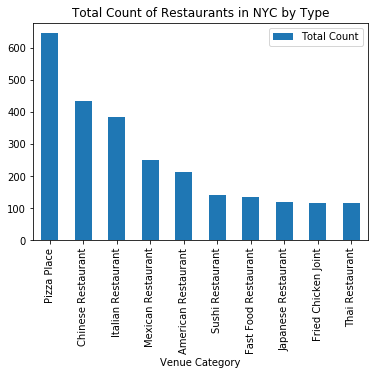

In [63]:
ax = df_count1.head(10).plot.bar(y='Total Count')
ax.set_title('Total Count of Restaurants in NYC by Type')

Create a heat map of the distribution of the top ten restaurant types.

In [64]:
ny_venues_clean.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
5,Wakefield,40.894705,-73.847201,Louis Pizza,40.898399,-73.848810,Pizza Place
6,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place
8,Co-op City,40.874294,-73.829939,Arby's,40.870280,-73.828611,Fast Food Restaurant
10,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant


In [0]:
restaurant_latlons = ny_venues_clean[['Venue Latitude','Venue Longitude']].to_numpy().tolist()
pizza_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='Pizza Place'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()
italian_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='Italian Restaurant'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()
chinese_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='Chinese Restaurant'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()
mex_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='Mexican Restaurant'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()
am_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='American Restaurant'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()
sushi_latlons = ny_venues_clean.loc[ny_venues_clean['Venue Category']=='Sushi Restaurant'][['Venue Latitude','Venue Longitude']].to_numpy().tolist()

In [35]:
address = 'Manhattan, New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_m = location.latitude
longitude_m = location.longitude
print('The geograpical coordinate of Manhattan, New York City are {}, {}.'.format(latitude_m, longitude_m))

The geograpical coordinate of Manhattan, New York City are 40.7896239, -73.9598939.


In [75]:
from folium.plugins import MarkerCluster
map_nyc_pizza = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in pizza_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_pizza.add_child(mc)
map_nyc_pizza

In [76]:

map_nyc_chinese = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in chinese_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_chinese.add_child(mc)
map_nyc_chinese

In [77]:
map_nyc_italian = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in italian_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_italian.add_child(mc)
map_nyc_italian

In [72]:
map_nyc_mex = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in mex_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_mex.add_child(mc)
map_nyc_mex

In [73]:
map_nyc_am = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in am_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_am.add_child(mc)
map_nyc_am

In [74]:
from folium.plugins import MarkerCluster
map_nyc_sushi = folium.Map(location=[latitude,longitude], zoom_start=11,width=1800, height=1000)
# add a marker for every record in the filtered data, use a clustered view
mc = MarkerCluster()
for each in sushi_latlons:
    mc.add_child(folium.Marker(location=[each[0],each[1]],
            clustered_marker = True))
map_nyc_sushi.add_child(mc)
map_nyc_sushi

## 4. Clustering the Neighborhoods

In [82]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues_clean[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues_clean['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot =ny_onehot[fixed_columns]
ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indian Sweet Shop,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
ny_onehot.columns[-1]

'Wings Joint'

And let's examine the new dataframe size.

In [84]:
ny_onehot.shape

(4596, 120)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [85]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indian Sweet Shop,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allerton,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.071429,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0

#### Let's confirm the new size

In [86]:
ny_grouped.shape

(283, 120)

#### Let's put the most common venues into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [88]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Breakfast Spot,Spanish Restaurant,American Restaurant,Falafel Restaurant,Gastropub
1,Annadale,Pizza Place,American Restaurant,Sushi Restaurant,Wings Joint,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
2,Arden Heights,Pizza Place,Wings Joint,Japanese Curry Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
3,Arlington,American Restaurant,Fast Food Restaurant,Wings Joint,German Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Polish Restaurant,Middle Eastern Restaurant,Taco Place,Mediterranean Restaurant,Filipino Restaurant,French Restaurant,Fish & Chips Shop,Falafel Restaurant


<a id='item4'></a>

## 5. K-means Clustering 

Run *k*-means to cluster the neighborhood into 5 clusters.

In [105]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)
print(kmeans)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


array([0, 4, 4, 2, 2, 4, 2, 0, 3, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [90]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except ValueError:
    pass
ny_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how='inner') # Use inner join here because some neighborhoods are dropped.

ny_merged.head(5) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Pizza Place,Caribbean Restaurant,Wings Joint,Dumpling Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,0,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,Wings Joint,Dumpling Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Seafood Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Wings Joint,Fried Chicken Joint,Egyptian Restaurant,Empanada Restaurant,English Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,2,Pizza Place,Latin American Restaurant,Mexican Restaurant,Chinese Restaurant,Fried Chicken Joint,Spanish Restaurant,Burger Joint,Breakfast Spot,Fast Food Restaurant,Wings Joint
6,Manhattan,Marble Hill,40.876551,-73.910660,2,Steakhouse,American Restaurant,Seafood Restaurant,Pizza Place,Fast Food Restaurant,Wings Joint,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant


Finally, let's visualize the resulting clusters

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 0

In [93]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,Wings Joint,Dumpling Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
8,Norwood,Pizza Place,Chinese Restaurant,American Restaurant,Cafeteria,Caribbean Restaurant,Burger Joint,Fried Chicken Joint,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant
11,Pelham Parkway,Italian Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Hunan Restaurant,Hotpot Restaurant,Egyptian Restaurant,Empanada Restaurant
13,Bedford Park,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Spanish Restaurant,Burger Joint,English Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
14,University Heights,Pizza Place,Chinese Restaurant,Latin American Restaurant,Fried Chicken Joint,Wings Joint,Burrito Place,Burger Joint,Spanish Restaurant,Fast Food Restaurant,African Restaurant


In [107]:
# statistics of the categories
# neighborhoods that are in Cluster 0:
cluster0 = ny_merged.loc[ny_merged['Cluster Labels'] == 0]['Neighborhood'].to_list()
print('Number of neighborhoods in cluster 0: {}'.format(len(cluster0)))
# all venues in these neighborhoods:
df_cluster0 = ny_venues_clean[['Venue Category','Neighborhood']].loc[ny_venues_clean['Neighborhood'].isin(cluster0)]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Count per neighborhood'})\
                .sort_values('Count per neighborhood',ascending=False).head(10)

df_cluster0['Count per neighborhood'] = df_cluster0['Count per neighborhood']/len(cluster0)
df_cluster0

Number of neighborhoods in cluster 0: 63


,Count per neighborhood
Venue Category,
Chinese Restaurant,2.730159
Pizza Place,2.444444
Italian Restaurant,0.714286
Mexican Restaurant,0.460317
Fried Chicken Joint,0.412698
Spanish Restaurant,0.396825
Sushi Restaurant,0.333333
American Restaurant,0.317460
Japanese Restaurant,0.269841


#### Cluster 1

In [95]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pizza Place,Caribbean Restaurant,Wings Joint,Dumpling Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
2,Eastchester,Caribbean Restaurant,Seafood Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Wings Joint,Fried Chicken Joint,Egyptian Restaurant,Empanada Restaurant,English Restaurant
9,Williamsbridge,Caribbean Restaurant,Soup Place,Wings Joint,Gastropub,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
41,Olinville,Chinese Restaurant,Caribbean Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Gastropub,Egyptian Restaurant,Empanada Restaurant,English Restaurant
54,Flatbush,Chinese Restaurant,Mexican Restaurant,Caribbean Restaurant,Pizza Place,Fast Food Restaurant,Middle Eastern Restaurant,Wings Joint,Gastropub,Empanada Restaurant,English Restaurant


In [108]:
# statistics of the categories
# neighborhoods that are in Cluster 1:
cluster2 = ny_merged.loc[ny_merged['Cluster Labels'] == 1]['Neighborhood'].to_list()
print('Number of neighborhoods in cluster 1: {}'.format(len(cluster2)))
# all venues in these neighborhoods:
df_cluster2 = ny_venues_clean[['Venue Category','Neighborhood']].loc[ny_venues_clean['Neighborhood'].isin(cluster2)]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Count per neighborhood'})\
                .sort_values('Count per neighborhood',ascending=False).head(10)

df_cluster2['Count per neighborhood'] = df_cluster2['Count per neighborhood']/len(cluster2)
df_cluster2


Number of neighborhoods in cluster 1: 15


,Count per neighborhood
Venue Category,
Caribbean Restaurant,2.733333
Chinese Restaurant,1.133333
Fast Food Restaurant,0.666667
Pizza Place,0.533333
Fried Chicken Joint,0.533333
Seafood Restaurant,0.266667
Mexican Restaurant,0.200000
Southern / Soul Food Restaurant,0.133333
Asian Restaurant,0.133333


#### Cluster 3

In [98]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kingsbridge,Pizza Place,Latin American Restaurant,Mexican Restaurant,Chinese Restaurant,Fried Chicken Joint,Spanish Restaurant,Burger Joint,Breakfast Spot,Fast Food Restaurant,Wings Joint
6,Marble Hill,Steakhouse,American Restaurant,Seafood Restaurant,Pizza Place,Fast Food Restaurant,Wings Joint,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant
10,Baychester,American Restaurant,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant,Fried Chicken Joint,Wings Joint,Gastropub,Egyptian Restaurant,Empanada Restaurant
12,City Island,Seafood Restaurant,Italian Restaurant,Pizza Place,Tapas Restaurant,Spanish Restaurant,French Restaurant,Fried Chicken Joint,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant
16,Fordham,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Fried Chicken Joint,Caribbean Restaurant,Mexican Restaurant,Buffet,Greek Restaurant


In [109]:
# statistics of the categories
# neighborhoods that are in Cluster 2:
cluster3 = ny_merged.loc[ny_merged['Cluster Labels'] == 2]['Neighborhood'].to_list()
print('Number of neighborhoods in cluster 2: {}'.format(len(cluster3)))
# all venues in these neighborhoods:
df_cluster3 = ny_venues_clean[['Venue Category','Neighborhood']].loc[ny_venues_clean['Neighborhood'].isin(cluster3)]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Count per neighborhood'})\
                .sort_values('Count per neighborhood',ascending=False).head(10)

df_cluster3['Count per neighborhood'] = df_cluster3['Count per neighborhood']/len(cluster3)
df_cluster3


Number of neighborhoods in cluster 2: 171


,Count per neighborhood
Venue Category,
Pizza Place,2.350877
Italian Restaurant,1.538012
Chinese Restaurant,1.356725
Mexican Restaurant,1.251462
American Restaurant,1.023392
Sushi Restaurant,0.666667
Thai Restaurant,0.614035
Fast Food Restaurant,0.590643
Japanese Restaurant,0.573099


#### Cluster 3

In [100]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Belmont,Italian Restaurant,Pizza Place,Mexican Restaurant,Wings Joint,Spanish Restaurant,American Restaurant,Eastern European Restaurant,Fast Food Restaurant,Japanese Restaurant,Thai Restaurant
39,Edgewater Park,Italian Restaurant,Pizza Place,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Japanese Restaurant,American Restaurant,Argentinian Restaurant,Gluten-free Restaurant,English Restaurant
66,Carroll Gardens,Italian Restaurant,Pizza Place,Thai Restaurant,French Restaurant,Greek Restaurant,Cuban Restaurant,Seafood Restaurant,Chinese Restaurant,Filipino Restaurant,Spanish Restaurant
117,Greenwich Village,Italian Restaurant,French Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,Lebanese Restaurant,Mediterranean Restaurant
152,Auburndale,Italian Restaurant,Korean Restaurant,Sushi Restaurant,Fast Food Restaurant,American Restaurant,Noodle House,Fried Chicken Joint,French Restaurant,Fish & Chips Shop,Filipino Restaurant


In [110]:
# statistics of the categories
# neighborhoods that are in Cluster 3:
cluster4 = ny_merged.loc[ny_merged['Cluster Labels'] == 3]['Neighborhood'].to_list()
print('Number of neighborhoods in cluster 3: {}'.format(len(cluster4)))
# all venues in these neighborhoods:
df_cluster4 = ny_venues_clean[['Venue Category','Neighborhood']].loc[ny_venues_clean['Neighborhood'].isin(cluster4)]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Count per neighborhood'})\
                .sort_values('Count per neighborhood',ascending=False).head(10)

df_cluster4['Count per neighborhood'] = df_cluster4['Count per neighborhood']/len(cluster4)
df_cluster4


Number of neighborhoods in cluster 3: 17


,Count per neighborhood
Venue Category,
Italian Restaurant,4.470588
Pizza Place,1.294118
American Restaurant,0.529412
Chinese Restaurant,0.352941
French Restaurant,0.352941
Sushi Restaurant,0.294118
Seafood Restaurant,0.235294
Fast Food Restaurant,0.235294
Greek Restaurant,0.235294


#### Cluster 4

In [102]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Woodlawn,Pizza Place,Italian Restaurant,American Restaurant,Indian Restaurant,German Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
20,Melrose,Pizza Place,Chinese Restaurant,Spanish Restaurant,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Gastropub,Egyptian Restaurant,Empanada Restaurant
33,Morris Park,Pizza Place,Burger Joint,Italian Restaurant,New American Restaurant,Arepa Restaurant,Mexican Restaurant,Buffet,Spanish Restaurant,Chinese Restaurant,French Restaurant
40,Castle Hill,Pizza Place,Latin American Restaurant,Southern / Soul Food Restaurant,Wings Joint,Gastropub,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
77,Manhattan Beach,Pizza Place,Wings Joint,Japanese Curry Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [106]:
# statistics of the categories
# neighborhoods that are in Cluster 4:
cluster5 = ny_merged.loc[ny_merged['Cluster Labels'] == 4]['Neighborhood'].to_list()
print('Number of neighborhoods in cluster 4: {}'.format(len(cluster5)))
# all venues in these neighborhoods:
df_cluster5 = ny_venues_clean[['Venue Category','Neighborhood']].loc[ny_venues_clean['Neighborhood'].isin(cluster5)]\
                .groupby(['Venue Category']).count().rename(columns={'Neighborhood' : 'Count per neighborhood'})\
                .sort_values('Count per neighborhood',ascending=False).head(10)

df_cluster5['Count per neighborhood'] = df_cluster5['Count per neighborhood']/len(cluster5)
df_cluster5


Number of neighborhoods in cluster 4: 21


,Count per neighborhood
Venue Category,
Pizza Place,2.857143
American Restaurant,0.380952
Chinese Restaurant,0.285714
Spanish Restaurant,0.190476
Fast Food Restaurant,0.190476
Seafood Restaurant,0.095238
Burger Joint,0.095238
Caribbean Restaurant,0.095238
Fried Chicken Joint,0.095238


<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).